In [1]:
# IMPORTS AND STANDING DATA
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

#status standing data
current_status = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-current-status.csv')
# Which AUs belong to which ministry standing data
au_ministry_data = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/srm-datapack/standing-data/standing-data-au-ministry.csv')
#current_status.iloc[64,0]
# Analysis date
analysis_date = datetime(2023, 3, 1)

In [2]:
# Import Raw Data
df = pd.read_csv(r'/Users/leogallagher/Documents/FMA-Work/KRG/PFM/Code/Expenditure/raw-data/srm-raw-data/230301-srm-raw-data.csv', low_memory=False)

In [3]:
# Define function to remove extra characters from current state string in the raw data
def remove_extra_chars(string):
    return string.split(' $')[0]

# Apply function to 'Current State' column
df['Current State'] = df['Current State'].apply(remove_extra_chars)

In [4]:
# Columns to keep immediately, filtering out the many columns that are unneeded in the raw data
df_columns_to_keep = [
        'Srid','Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Entity','Account Code','Exchange Rate','Total Cost Of Line','Amended Total Cost Of Line',
        'Savings Of Line','Total Sr Savings','Spending Team Action','Spending Team Action Date',
        'Price Evaluation Action','Price Evaluation Action Date','Engineering Directorate Action',
        'Engineering Directorate Action Date','Publications Directorate Action','Publications Directorate Action Date',
        'Director Of Spending Action','Director Of Spending Action Date','Dg Pa Action','Dg Pa Action Date',
        'Minister Of Finance Action','Minister Of Finance Action Date','Com Action','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date','Second Round Com Action Date',
        'Second Round Final Approval Date','Final Approval Date','Current State']
df_filtered = df.loc[:, df_columns_to_keep]
#df_filtered.head(5)

In [5]:
# Create a Most Recent Action column
#columns to include are all the columns from which the 'most recent action' could be. I.e. the most recent action
# is the date that is most recent of the actions listed below.
columns_to_include = [
        'Date Submitted To Mofe','Approval Number Issued At','Ministry Input Id Issued At',
        'Ministry Id Issued At','Ministry Diwan Reviewer Action Date','Ministry Diwan Decision Maker Action Date',
        'Spending Team Action Date',
        'Price Evaluation Action Date',
        'Engineering Directorate Action Date','Publications Directorate Action Date',
        'Director Of Spending Action Date','Dg Pa Action Date',
        'Minister Of Finance Action Date','Com Action Date',
        'Second Round Ministry Diwan Reviewer Action Date','Second Round Ministry Diwan Decision Maker Action Date',
        'Second Round Spending Team Action Date','Second Round Director Of Spending Action Date',
        'Second Round Dg Pa Action Date','Second Round Minister Of Finance Action Date',
        'Second Round Com Action Date','Second Round Final Approval Date','Final Approval Date']

df_filtered['Most Recent Action'] = df_filtered[columns_to_include].max(axis=1)

# convert date_column to datetime format
df_filtered['Most Recent Action'] = pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d %I:%M %p', errors='coerce').fillna(pd.to_datetime(df_filtered['Most Recent Action'], format='%Y-%m-%d', errors='coerce'))

In [6]:
# Display updated dataframe
#df['Current State'].unique()

# Merge standing data and raw data to get the status columns
current_status['Current State'] = current_status['Current State'].str.upper()
df_filtered['Current State'] = df_filtered['Current State'].str.upper()
df_filtered = pd.merge(df_filtered, current_status,how='left', on='Current State')

In [7]:
# ADD STATUS COLUMN
def final_status(row):
    if row['Current State'] == "REVOKED" and row['Date Submitted To Mofe'] == "-":
        
        return "Not Submitted"
    
    elif row['Current State'] == "REVOKED" and row['Final Approval Date'] != "-":
        if row['Minister Of Finance Action'] == "Approved By Minister Of Finance" or row['Minister Of Finance Action'] == "Amended and Approved By Minister Of Finance" or  row['Minister Of Finance Action'] == "Pending Tender":
                
            return "Revoked After Approval"
        
        elif row['Com Action'] == "Approved By Council Of Ministers" or row['Com Action'] == "Amended And Approved By Council Of Ministers" or row['Com Action'] == "Pending Tender By Council Of Ministers":
                
            return "Revoked After Approval"
        
        elif row['Minister Of Finance Action'] == "Rejected By Minister Of Finance" or row['Com Action'] == "Rejected By Council Of Ministers":
                
            return "Revoked After Rejection"
        
    elif row['Status'] == 'In process':
        return 'In Process'
    
    elif row['Status'] == 'Not submitted':
        return 'Not Submitted'
    
    elif row['Status'] == 'Revoked':
        return 'Revoked'
    
    elif row['Status'] == 'Rejected':
        return 'Rejected'
    
    elif row['Status'] == 'Approved':
        if row['Total Sr Savings'] == 0:
            return 'Approved'
        else:
            return 'Amended'
    else:
        return np.nan
    
df_filtered['Final Status'] = df_filtered.apply(final_status, axis=1)

In [8]:
# Replace '-' values with zeros in the 'Savings Of Line' column and blanks in the exchange rate column
# same for amended total cost of line, and total cost of line. and exchange rate remove na's

df_filtered['Savings Of Line'] = df_filtered['Savings Of Line'].replace('-', 0).fillna(0)
df_filtered['Amended Total Cost Of Line'] = df_filtered['Amended Total Cost Of Line'].replace('-', 0).fillna(0)
df_filtered['Total Cost Of Line'] = df_filtered['Total Cost Of Line'].replace('-', 0).fillna(0)
df_filtered['Exchange Rate'] = df_filtered['Exchange Rate'].fillna(0)

# Convert the 'Savings Of Line' column to float type
df_filtered['Savings Of Line'] = df_filtered['Savings Of Line'].astype(float)
# Convert the 'Amended Total Cost Of Line' column to float type
df_filtered['Amended Total Cost Of Line'] = df_filtered['Amended Total Cost Of Line'].astype(float)
# Convert the 'Savings Of Line' column to float type
df_filtered['Total Cost Of Line'] = df_filtered['Total Cost Of Line'].astype(float)

In [9]:
### ADD 'LINE ITEM SAVINGS IQD'
df_filtered['Line Item Savings IQD'] = df_filtered.apply(lambda row:
                                                         row['Exchange Rate'] * row['Savings Of Line'], axis=1)
### ADD 'Amended Line Item IQD'
df_filtered['Amended Line Item IQD'] = df_filtered.apply(lambda row:
                                                         row['Exchange Rate'] * row['Amended Total Cost Of Line'], axis=1)
### Add 'Original Line Item IQD'
df_filtered['Original Line Item IQD'] = df_filtered.apply(lambda row:
                                                         row['Exchange Rate'] * row['Total Cost Of Line'], axis=1)
### ADD 'Original Total Cost of SR'

# Group the rows of the DataFrame by the values in 'Srid',
# and calculate the sum of 'Original Line Item IQD' for each group
sum_original = df_filtered.groupby('Srid')['Original Line Item IQD'].sum()

# Create a new column 'Original Total Cost of SR' with the calculated values
df_filtered['Original Total Cost of SR'] = df_filtered['Srid'].map(sum_original)

# Code to make the table for the graph

In [11]:
df_filtered.columns


Index(['Srid', 'Date Submitted To Mofe', 'Approval Number Issued At',
       'Ministry Input Id Issued At', 'Ministry Id Issued At',
       'Ministry Diwan Reviewer Action Date',
       'Ministry Diwan Decision Maker Action Date', 'Entity', 'Account Code',
       'Exchange Rate', 'Total Cost Of Line', 'Amended Total Cost Of Line',
       'Savings Of Line', 'Total Sr Savings', 'Spending Team Action',
       'Spending Team Action Date', 'Price Evaluation Action',
       'Price Evaluation Action Date', 'Engineering Directorate Action',
       'Engineering Directorate Action Date',
       'Publications Directorate Action',
       'Publications Directorate Action Date', 'Director Of Spending Action',
       'Director Of Spending Action Date', 'Dg Pa Action', 'Dg Pa Action Date',
       'Minister Of Finance Action', 'Minister Of Finance Action Date',
       'Com Action', 'Com Action Date',
       'Second Round Ministry Diwan Reviewer Action Date',
       'Second Round Ministry Diwan Decision

In [17]:
# Filter unnecessary rows
keep_cols = [
    'Srid', 'Date Submitted To Mofe',
    'Most Recent Action', 'Final Status',
       'Line Item Savings IQD', 'Amended Line Item IQD']
val_stat_bar_df = df_filtered.loc[:,keep_cols].set_index('Most Recent Action')
val_stat_bar_df['2022-06-01':'2023-03-01']

/var/folders/4k/snk4vz6j1ylg55j18vmzq7dc0000gn/T/ipykernel_43209/441444356.py:7: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  val_stat_bar_df['2022-06-01':'2023-03-01']


Srid Date Submitted To Mofe Final Status  \
Most Recent Action                                                    
2022-10-30 11:02:00    SRID-147                      -   In Process   
2022-08-07 00:00:00    SRID-460    2020-09-27 03:04 pm     Approved   
2022-08-07 00:00:00    SRID-460    2020-09-27 03:04 pm     Approved   
2022-08-21 12:00:00    SRID-499    2021-06-27 03:08 pm   In Process   
2022-10-30 11:03:00    SRID-522                      -   In Process   
...                         ...                    ...          ...   
2023-03-01 10:33:00  SRID-25889                      -   In Process   
2023-03-01 10:33:00  SRID-25889                      -   In Process   
2023-03-01 10:33:00  SRID-25889                      -   In Process   
2023-03-01 10:33:00  SRID-25889                      -   In Process   
2023-02-28 18:59:00  SRID-25929                      -   In Process   

                     Line Item Savings IQD  Amended Line Item IQD  
Most Recent Action                                                 
2022-10-30 11:02:00                    0.0                    0.0  
2022-08-07 00:00:00                    0.0            375000000.0  
2022-08-07 00:00:00                    0.0            375000000.0  
2022-08-21 12:00:00                    0.0              1277500.0  
2022-10-30 11:03:00                    0.0              4900000.0  
...                                    ...                    ...  
2023-03-01 10:33:00                    0.0               500000.0  
2023-03-01 10:33:00                    0.0              2000000.0  
2023-03-01 10:33:00                    0.0              5000000.0  
2023-03-01 10:33:00                    0.0              1600000.0  
2023-02-28 18:59:00                    0.0              8210000.0  

[60557 rows x 5 columns]

In [19]:
val_stat_bar_df.columns


Index(['Srid', 'Date Submitted To Mofe', 'Final Status',
       'Line Item Savings IQD', 'Amended Line Item IQD'],
      dtype='object')

In [87]:
# Approved DF
# create a list of final status values to filter on
final_status_list = ['Approved', 'Amended', 'Revoked After Approval']
# filter the dataframe using the isin() method
approved_df = val_stat_bar_df[val_stat_bar_df['Final Status'].isin(final_status_list)].loc[:,['Line Item Savings IQD','Amended Line Item IQD']].resample('M').sum()

# Amended df
amended_df = val_stat_bar_df[val_stat_bar_df['Final Status'] == 'Amended'].loc[:,['Line Item Savings IQD','Amended Line Item IQD']].resample('M').sum()

# Rejected df
rejected_df = val_stat_bar_df[val_stat_bar_df['Final Status'] == 'Rejected'].loc[:,['Line Item Savings IQD','Amended Line Item IQD']].resample('M').sum()



In [88]:
approved_df = approved_df['2022-06-01':'2023-06-01']
amended_df = amended_df['2022-06-01':'2023-06-01']
rejected_df = rejected_df['2022-06-01':'2023-06-01']


In [92]:
rejected_df['Amended Line Item IQD'].dtype

dtype('float64')

In [108]:
#months = approved_df.index.to_period('m').astype('str')

months = ['Jun', 'Jul', 'Aug', 'Sep','Oct','Nov','Dec','Jan','Feb']

sub_data = {'Approved': approved_df['Amended Line Item IQD'],
           'Savings from Amendments': amended_df['Line Item Savings IQD'] ,
           'Rejected': rejected_df['Amended Line Item IQD']
           }

In [82]:
rejected_df.index

PeriodIndex(['2022-06', '2022-07', '2022-08', '2022-09', '2022-10', '2022-11',
             '2022-12', '2023-01', '2023-02'],
            dtype='period[M]', name='Most Recent Action')

# Plot the bar chart

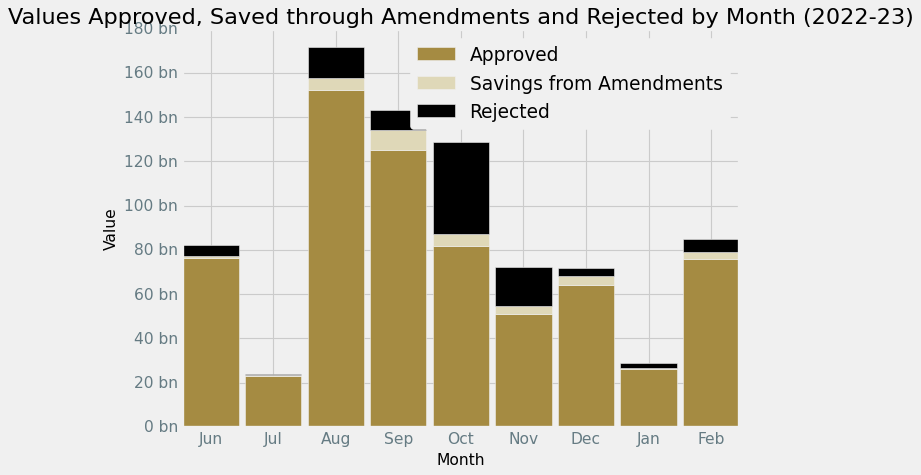

In [120]:
# Define the style
plt.style.use('fivethirtyeight')

# Define the first bar chart

width = 0.9

colors = ['#a58b4280','#dfd8b880','#000000']
fig, ax = plt.subplots()
bottom = np.zeros(9)

for i, (boolean, sub_datap) in enumerate(sub_data.items()):
    p = ax.bar(months, sub_datap, width, label=boolean, bottom=bottom, color=colors[i],alpha=1)
    bottom += sub_datap
    

ax.set_title("Values Approved, Saved through Amendments and Rejected by Month (2022-23)")
ax.set_xlabel('Month')
ax.set_ylabel('Value')
ax.legend(loc="upper right")

# Format y-axis ticks
fmt = lambda x, pos: f'{x / 1e9:.0f} bn'
ax.yaxis.set_major_formatter(mtick.FuncFormatter(fmt))

plt.show()